# Analysis - Stack Overflow Surveys 2011 - 2020

This scripts takes the results from 2011-2020, which were combined into a single dataframe in the condition.ipynb notebook.

Made up of the following columns

- target_cols : 'salary'
- numerical_cols : 'age', 'years_coding', 'org_size'
- categorical_cols : 'os', 'satisfaction', 'job_seek', 'remote', 'gender', 'industry', 'employment',
- dummy_cols = 'occupation', 'education'
- other = 'survey_year', 'countries'

In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from routines import xzload, mpl_defs, stackplot

colours = mpl_defs()

def pc50(x):
    ''' returns the 50th percentile, ignoring NaNs '''
    return np.nanpercentile(x, 50)

First load the dataset. I plot the counts for each question versus survey year, which shows a strong variability. Also note that the reach of the survey increases dramatically from 2015, with almost 100000 in 2019.

survey_year,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
age,2729,5964,9434,7346,25492,55336,0,64574,79210,45446
country,2813,6243,9741,7643,25279,55528,51392,98443,88751,64072
education_associate_degree,0,0,0,0,0,0,0,98855,88883,64461
education_bachelors,0,0,0,0,26086,56030,51392,98855,88883,64461
education_bootcamp,0,0,0,0,26086,56030,51392,98855,88883,0
education_college,0,0,0,0,26086,56030,51392,98855,88883,64461
education_competition,0,0,0,0,0,0,51392,98855,88883,0
education_doctoral,0,0,0,0,26086,56030,51392,98855,88883,64461
education_elementary,0,0,0,0,0,0,51392,98855,88883,64461
education_hackathon,0,0,0,0,0,0,51392,98855,88883,0


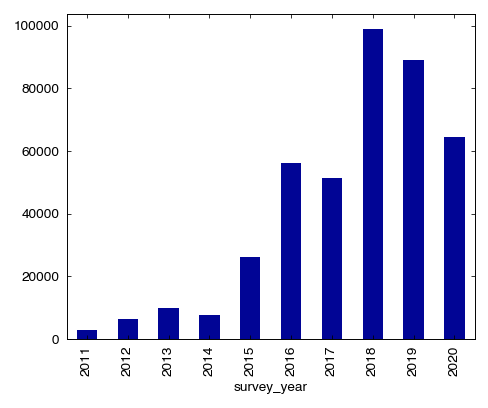

In [2]:
df = xzload("surveys.pz")
fig, ax = plt.subplots()
df.value_counts(subset='survey_year').sort_index().plot(kind="bar",ax=ax)
df.groupby("survey_year").count().T

Now we can start looking at each question. First up, participant age

## Participant Age

Let's look at the means as well as box and wisker plot to evaluate the distrubution of each year. Note that the question wasn't asked in 2017.

Interestingly the mean stays relatively constant, despite changes to the way the question is asked. Before 2019, the response was provided as categorical ranges (the median value of the groups was selected). In 2019 to 2020 this question became numerical, but but unless there really is a 275 year old coder out there, we can assume some respondents did not answer seriously.

/Users/joel/Library/miniforge3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(


,mean,std,pc50
survey_year,,,
2011,30.370465,7.898700,27.0
2012,28.981556,7.897231,27.0
2013,30.083634,8.880713,27.0
2014,29.171250,8.736102,27.0
2015,28.911384,8.461626,27.0
2016,29.822719,9.022794,27.0
2017,NaN,NaN,NaN
2018,30.879410,8.912042,30.0
2019,30.336699,9.178390,29.0


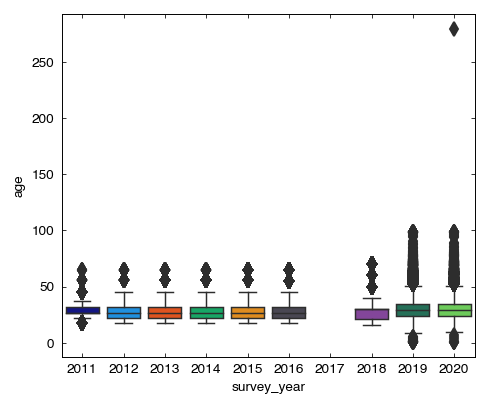

In [3]:
age = df.groupby("survey_year")["age"].agg(["mean", "std", pc50])
sns.boxplot(data=df, x="survey_year", y="age")
age

Let's remove these outliers from the dataframe by slightly cutting the outer quantile and look at the data again. This will remove these entries completely as I'm assuming that someone who answered this question incorrectly was not serious about filling out the survey.

/Users/joel/Library/miniforge3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(


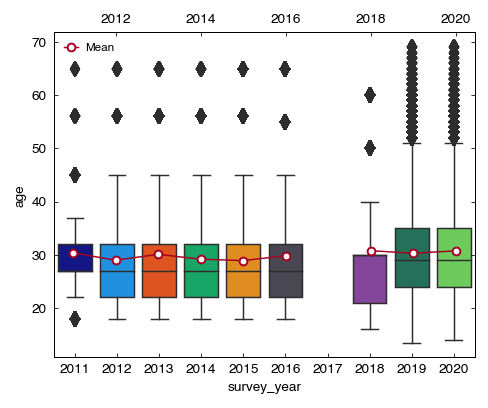

In [4]:
Q = (0.001, 0.999)
df = df[(df.survey_year == 2017) | ((df.age < df.age.quantile(Q[1])) & (df.age > df.age.quantile(Q[0])))]

fig, ax = plt.subplots()
sns.boxplot(data=df, x="survey_year", y="age", ax=ax)

age = df.groupby("survey_year")["age"].agg(["mean", "std", pc50])
axt = ax.twiny()
axt.plot(age["mean"], 'o-', mfc='w', label="Mean", color=colours[-1])
axt.legend(loc=2)


That's better. Interestingly despite the change in style of question, the mean age remains around 30 years old, although there does seem to be some sort of trend towards a broader distribution.

Notably, from this we can say that the dramatic increase in partipants after 2014 also doesn't seem to have any impact upon average age.

## Years Coding

Let's see how the the number of years each participent has coded for also changes over time

,mean,std,pc50
survey_year,,,
2011,7.459509,3.513577,8.0
2012,6.405600,3.713988,8.0
2013,6.701293,3.745201,8.0
2014,6.157773,3.813739,8.0
2015,6.723255,5.230673,3.0
2016,7.033112,5.308980,3.0
2017,10.709493,6.936689,9.0
2018,10.526351,7.840898,7.0
2019,11.508761,8.717525,9.0


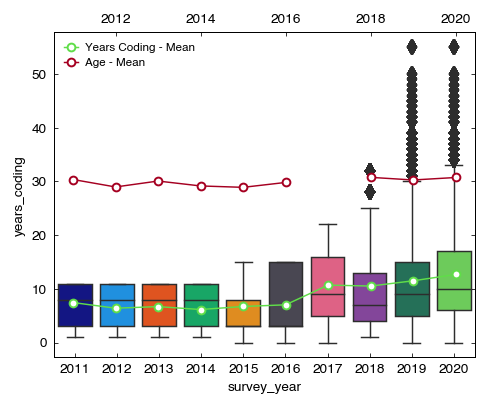

In [5]:
fig, ax = plt.subplots()
g = sns.boxplot(data=df, x="survey_year", y="years_coding", ax=ax)

yc = df.groupby("survey_year")["years_coding"].agg(["mean", "std", pc50])
axt = ax.twiny()
axt.plot(yc["mean"], 'o-', mfc='w', label="Years Coding - Mean", color=colours[-2])
axt.plot(age["mean"], 'o-', mfc='w', label="Age - Mean", color=colours[-1])
axt.legend(loc=2)

yc

The years coding does seem to increase over time when looking at both the mean and 50th percentile. At the same time, the average age remained mostly constant. This is likely due to the change in question format, or perhaps participants in later years starting picking up coding at an earlier age. Finally, we can compare age and years coding for the 2015 and 2020. Which really shows the strong correlation between the distributions.

Looks like then almost everyone begins their coding journey in their teens.

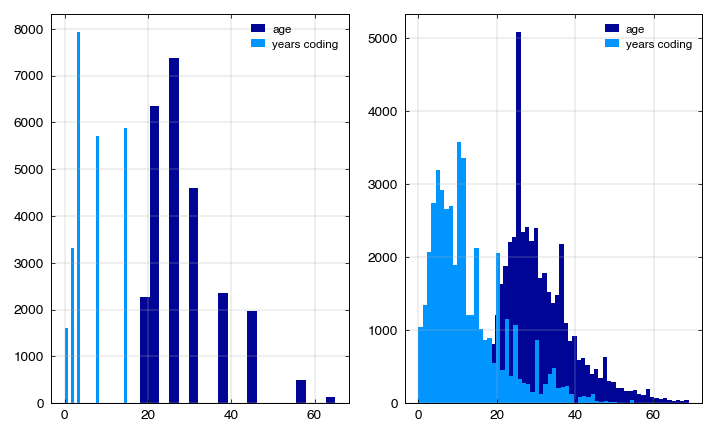

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(5, 3))
for ax, bins, year in zip(axes, [20, 50], [2015, 2020]):
    df[df.survey_year == year]["age"].hist(bins=bins, ax=ax, label='age')
    df[df.survey_year == year]["years_coding"].hist(bins=bins, ax=ax, label='years coding')
    ax.legend()


## Organisation Size

Organisation spread is decididly non-linear, ranging from self-employed to corporations 10000+. We can see how changes in the bucketing of the question options changes over time, by plotting violin plots and limiting the maximum org_size. In 2014 and 2015 the question was not asked.

<AxesSubplot:xlabel='survey_year', ylabel='org_size'>

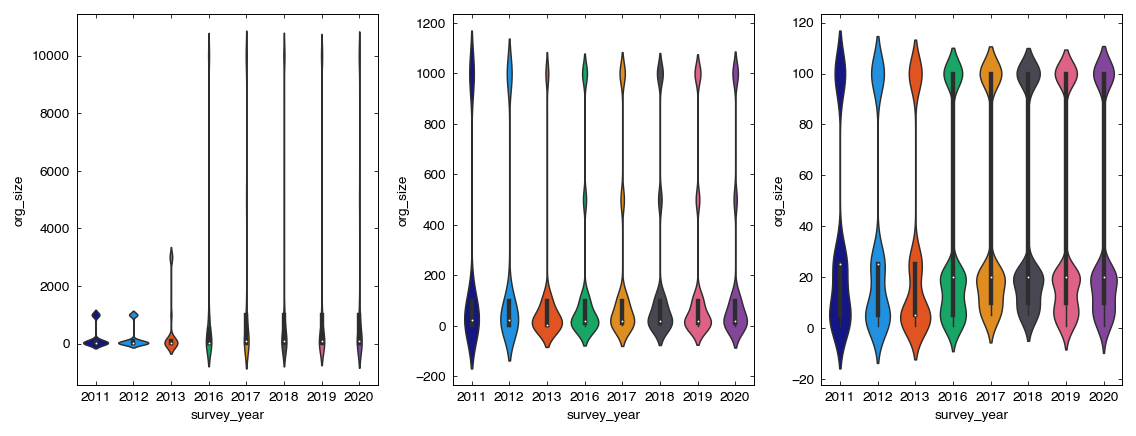

In [7]:
years = [2011, 2012, 2013, 2016, 2017, 2018, 2019, 2020]
org = df.loc[df.survey_year.isin(years)]

fig, ax = plt.subplots(1, 3, figsize=(8, 3))
sns.violinplot(data=org, x="survey_year", y="org_size", ax=ax[0])
sns.violinplot(data=org[org.org_size < 3000], x="survey_year", y="org_size", ax=ax[1])
sns.violinplot(data=org[org.org_size < 300], x="survey_year", y="org_size", ax=ax[2])


The data will be re-binned to account for the differences in question style. Only 2016+ sets are used when the survey accounted for larger companies. Here we can see no major changes through the years.

survey_year,2016,2017,2018,2019,2020
<10,19.77,10.19,9.96,16.12,14.28
10-50,32.22,33.96,34.35,30.89,31.28
50-100,17.40,19.46,19.69,17.97,19.06
100-500,5.90,6.65,6.58,6.44,6.51
500-1000,9.19,10.25,10.96,10.51,11.13
1000-10000,3.50,4.29,4.34,4.12,4.12
>10000,12.02,15.20,14.11,13.94,13.62


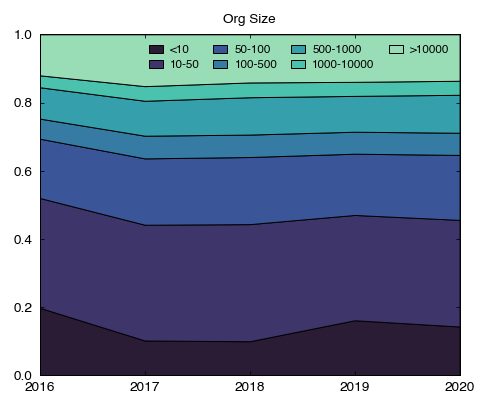

In [8]:
years = [2016, 2017, 2018, 2019, 2020]
org = df.loc[df.survey_year.isin(years)].copy()

bins = pd.IntervalIndex.from_tuples([
    (0, 9),
    (9, 60),
    (60, 300),
    (300, 800),
    (800 , 1200),
    (1200, 6000),
    (6000, 1E6)
])

org["org_cut"] = pd.cut(org.org_size, bins)

org2 = org.groupby("survey_year")["org_cut"].value_counts(normalize=True).unstack()
org2.columns = ['<10', '10-50', '50-100', '100-500', '500-1000', '1000-10000', '>10000']

ax = stackplot(org2, "Org Size")
ax.legend(ncol=4)
np.round(org2.T*100, 2)

## Preferred Operating System

This is a rather enlightening result, and interestingly one that has been asked every year except 2017. There is a clear trend in reduced windows usage that is offset by equal increases in Linux and MacOS usage. No wonder Microsoft has been working on improving their developer toolkits in recent years!

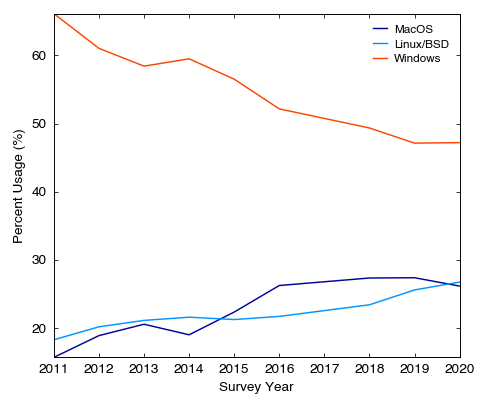

In [55]:
mpl_defs(1, 1)
fig, ax = plt.subplots()
os = df.groupby('survey_year')['os'].value_counts(normalize=True).sort_index().unstack()
os.columns = ["MacOS", "Linux/BSD", "Windows"]
(os*100).plot(ax=ax)
ax.set_title('Most used Operating System')
ax.set_xticks(range(2011,2021))
ax.margins(0,0)
ax.set_ylabel('Percent Usage (%)')
ax.set_xlabel('Survey Year')
ax.set_title('')
plt.savefig('os.png')

Let's look at OS use by profession. Perhaps the changes in types of profession over time may impact OS usage. Definitely the less traditional occupations 

<AxesSubplot:>

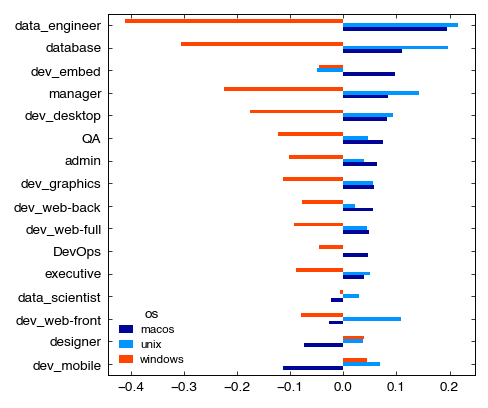

In [10]:
occ_cols = [c for c in df.columns if c.startswith("occupation")]
occ = df[["survey_year", "os"]+occ_cols].groupby(["survey_year","os"]).sum()

occ2015 = occ.loc[2015].divide(occ.loc[2015].sum(axis=0).values, axis=1)
occ2020 = occ.loc[2020].divide(occ.loc[2020].sum(axis=0).values, axis=1)

occ = occ2020 - occ2015
occ.columns = [c.split("_", 1)[-1] for c in occ_cols]
occ.T.dropna().sort_values(by="macos").plot(kind="barh")


## Satisfaction

Satisfaction was not that easy to follow, as the nature of the question changes over time.
- The most negative option in 2011 was "FML", "I hate my job" in 2012, which has a different connotation to "very disatisified" in 2019.
- The number of options changed in 2017, and 2018, which also skews the way respondents answer. These years have been removed.

With these caveats, we can have a look.


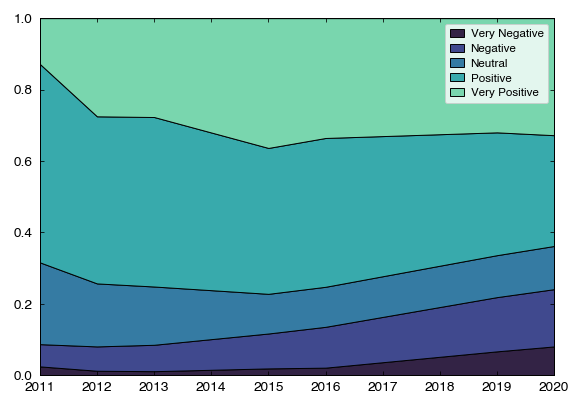

In [43]:
# %% satisfaction

sat = df.groupby("survey_year")["satisfaction"].value_counts(normalize=True).sort_index().unstack()
sat.columns = ['Very Negative', 'Negative', 'Neutral', 'Positive', 'Very Positive']
ax = stackplot(sat.drop([2017, 2018]), "")
plt.savefig('satisfaction.png')


Interestingly, in recent years while those who stay very positive have remained relatively constant, it seems like there are less that see their work environment positively. Lets see if we can trace that down to an individual industry...

In [46]:
occ_cols = [c for c in df.columns if c.startswith("occupation")]

occ = df[["survey_year", "satisfaction"]+occ_cols].groupby(["survey_year","satisfaction"]).sum()
occ.columns = [c.split("_", 1)[-1] for c in occ_cols]

occ2015 = occ.loc[2015].divide(occ.loc[2015].sum(axis=0).values, axis=1)
occ2020 = occ.loc[2020].divide(occ.loc[2020].sum(axis=0).values, axis=1)

occ2015

occ = occ2020 - occ2015
occ.T.dropna().sort_values(by=5, ascending=False).plot(kind="barh")
plt.savefig('satisfaction_vs_occupation_2020-2015.png')

,DevOps,QA,academic,admin,analyst,data_engineer,data_scientist,database,designer,dev_desktop,...,dev_web,dev_web-back,dev_web-front,dev_web-full,executive,manager,non-tech,other,sales,student
satisfaction,,,,,,,,,,,,,,,,,,,,,
1.0,0.025090,0.054264,NaN,0.019231,NaN,0.039474,0.022333,0.021978,0.029703,0.025888,...,NaN,0.020069,0.015368,0.014944,0.012539,0.000000,NaN,0.12500,NaN,0.044218
2.0,0.125448,0.108527,NaN,0.100000,NaN,0.164474,0.071960,0.087912,0.089109,0.108728,...,NaN,0.111812,0.076839,0.097492,0.043887,0.203008,NaN,0.06250,NaN,0.081633
3.0,0.096774,0.108527,NaN,0.119231,NaN,0.065789,0.099256,0.065934,0.118812,0.104290,...,NaN,0.130161,0.104281,0.113325,0.043887,0.127820,NaN,0.15625,NaN,0.115646
4.0,0.379928,0.379845,NaN,0.407692,NaN,0.401316,0.421836,0.450549,0.356436,0.429734,...,NaN,0.409977,0.424808,0.416118,0.341693,0.436090,NaN,0.28125,NaN,0.476190
5.0,0.372760,0.348837,NaN,0.353846,NaN,0.328947,0.384615,0.373626,0.405941,0.331361,...,NaN,0.327982,0.378705,0.358121,0.557994,0.233083,NaN,0.37500,NaN,0.282313


So mostly positive has really dropped across the board. However, we can see the biggest losers, as it were, are really in the mobile industry.

## Currently Looking for a Job

Most people are open to new opportunities but are not actively looking. Perhaps there is a slight trend to more people actively looking.

,Actively looking,Not looking,Open to new opportunities
survey_year,,,
2014,0.535777,0.464223,NaN
2015,0.099783,0.307941,0.592276
2016,0.154434,0.217306,0.628260
2017,0.130947,0.248053,0.621001
2018,0.151672,0.249777,0.598552
2019,0.145519,0.267112,0.587369
2020,0.163329,0.258025,0.578646


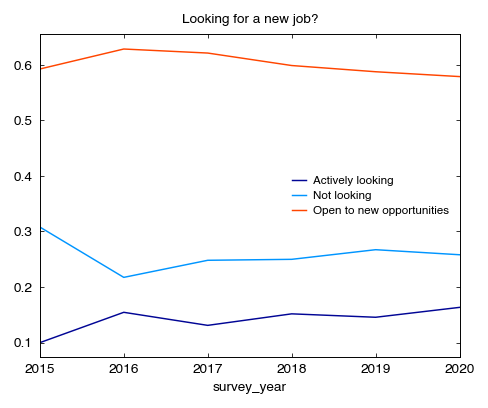

In [13]:
fig, ax = plt.subplots()
js = df.groupby("survey_year")["job_seek"].value_counts(normalize=True).sort_index().unstack()
js.columns = ["Actively looking", "Not looking", "Open to new opportunities"]
js.drop(2014).plot(ax=ax)
ax.set_title('Looking for a new job?')
ax.set_xticks(range(2011,2021))
ax.margins(0, 0.05)
js

## Employment Type

The variablity is too large to make any definite statements here

survey_year,2015,2016,2017,2018,2019,2020
Not employed (student/retired/unemployed),18.44,15.03,11.42,9.32,10.28,15.41
Independent (contractor/self-employed),9.19,11.62,10.40,9.88,9.61,8.81
Part time position,4.35,3.63,6.32,5.20,5.12,3.33
Full time position,68.03,69.72,71.86,75.60,75.00,72.44


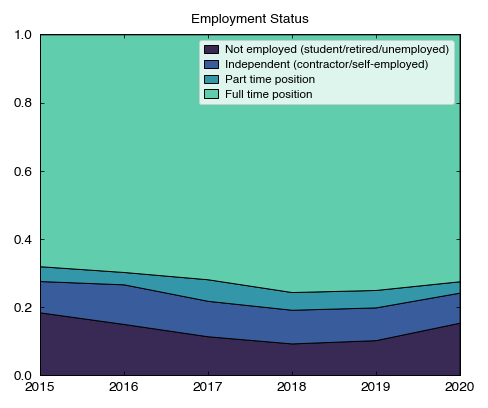

In [14]:
emp = df.groupby("survey_year")["employment"].value_counts(normalize=True).sort_index().unstack()
emp = emp[["not-employed", "independent", "part-time", "full-time"]]
emp.columns = [
    "Not employed (student/retired/unemployed)",
    "Independent (contractor/self-employed)",
    "Part time position",
    "Full time position"
]
ax = stackplot(emp, "Employment Status")
np.round(emp.T*100, 2)

## Remote Work

This question is vague way of questioning. The question reponse categories was tweaked a lot over the years, which I've attempted to group into general catergories (see ```map_values.py```).

Still, it's interesting to see a slight consistent increase in full time remote workers. The question was not asked in the 2020 survey, which in any case was taken before the pandemic really took affect. However, it would be interesting to see just how much things change for 2021.

survey_year,2014,2015,2016,2017,2019
Never,36.10,22.84,22.34,31.76,43.26
Occasionaly,43.39,48.10,47.92,48.74,38.70
Part time,9.96,18.61,17.63,8.36,5.99
All the time,10.56,10.45,12.11,11.15,12.05


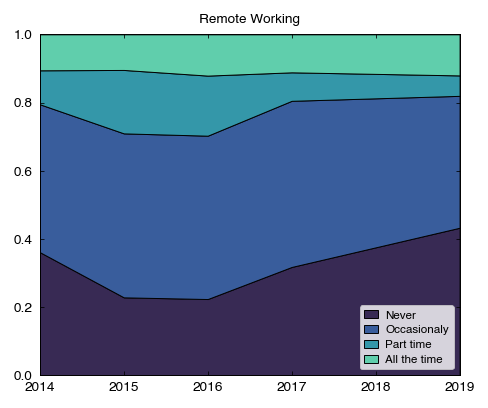

In [15]:
rem = df.groupby("survey_year")["remote"].value_counts(normalize=True).sort_index().unstack()
rem = rem[["never",  "occasional", "part_time", "full_time"]]
rem.columns = ["Never", "Occasionaly", "Part time", "All the time"]
ax = stackplot(rem, 'Remote Working')
ax.legend(loc=4, frameon=True)

np.round(rem.T*100, 2)

## Gender

Gender is a sticky one. To be more inclusive the question was switched from a binary option to multiselect. Purely to keep it simple, I've grouped the response into Male, Female, and those who doesn't conform to this dichotomy.

survey_year,2014,2015,2016,2017,2018,2019,2020
gender,,,,,,,
female,4.9,5.8,5.8,5.1,6.1,7.1,7.3
male,95.1,93.7,93.4,61.5,90.6,90.4,90.1
other,NaN,0.4,0.9,33.5,3.3,2.5,2.6


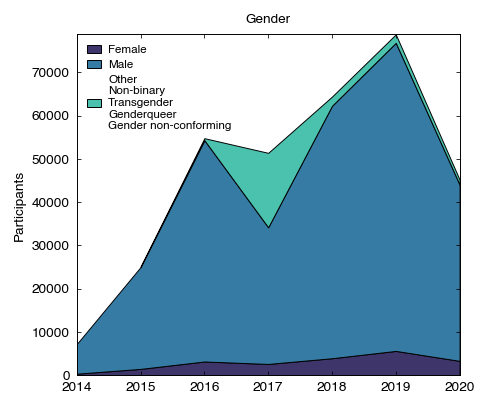

In [16]:
gen = df.groupby("survey_year")["gender"].value_counts().sort_index().unstack()
gen.columns = ["Female", "Male", "Other\nNon-binary\nTransgender\nGenderqueer\nGender non-conforming"]
ax = stackplot(gen, "Gender")
ax.legend(loc=2)
ax.set_ylabel('Participants')

gen = df.groupby("survey_year")["gender"].value_counts(normalize=True).sort_index().unstack()
np.round(gen.T*100, 1)

We do see a clear trend towards more inclusivity from 2014-2020, which is nice. My guess is the anomously large size in 2017 is likely due to particpants enjoying the novelty of the multiselect gender question when it was first introduced.

We can quickly look at gender salary diparity between men and women, which seems to hover around 90%, about that expected for the average age (30) of the participents (https://en.wikipedia.org/wiki/Gender_pay_gap_in_the_United_States)

In [17]:
gen = df.groupby(["survey_year","gender"])["salary"].mean().sort_index().unstack()
gen["female"]/gen["male"] * 100


survey_year
2014     89.421486
2015     73.195126
2016     86.534713
2017    101.907890
2018     91.490772
2019     89.996710
2020     94.389649
dtype: float64

## Industry

This question was only asked up to 2017, and in 2017 the question changed to focus on the split between private and public sectors. In addition, the number of options increased each year. Here I focus on the groups that were available across all years.

survey_year,2011,2012,2013,2014,2015,2016
industry,,,,,,
consulting,11.8,10.4,9.3,9.1,7.0,7.0
education,5.8,5.8,7.1,4.1,4.0,3.8
finance,6.9,5.8,5.6,6.6,7.5,8.5
gaming,1.8,2.3,2.0,2.0,2.1,2.4
healthcare,3.0,2.7,2.9,3.9,4.3,4.4
manufacturing,2.8,2.9,2.7,3.6,3.2,2.7
non-profit,1.8,1.4,1.7,1.2,0.9,1.0
retail,2.1,1.9,1.9,2.6,2.5,2.6
software,29.8,31.6,31.1,28.0,24.9,22.3


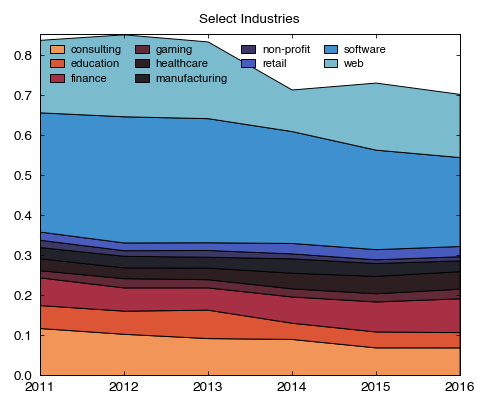

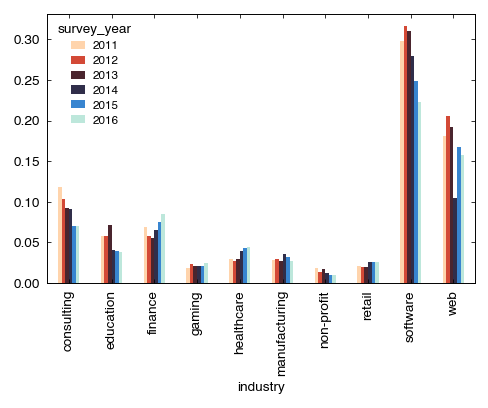

In [18]:
ind = df.groupby("survey_year")["industry"].value_counts(normalize=True).sort_index().unstack()

ind = ind[[
    "consulting",
    "education",
    "finance",
    "gaming",
    "healthcare",
    "manufacturing",
    "non-profit",
    "retail",
    "software",
    "web"
]].drop(2017)

ax = stackplot(ind, "Select Industries", cmap="icefire_r")
ax.legend(loc=2, fontsize='small', ncol=4)

np.round(ind.T*100, 1)
ind.T.plot(kind="bar", cmap="icefire_r")

np.round(ind.T*100, 1)

Perhaps the clearest trend is the decrease in the relative proportion of generic "software" and "web" industries, as it's being replaced increase in other industries like "finance" and "healthcare", as computing becomes more important in these fields.


## Occupation

First the contribution of each occupation is plotted as a factor of the total. This doesn't reflect the true distribution as  respondents could select multiple options. However, we can still observe some interesting trends. Interestingly, the biggest "loser" is probably desktop developers, while we also see the emergence of a clearer deliniation between front-end and back-end web developers.

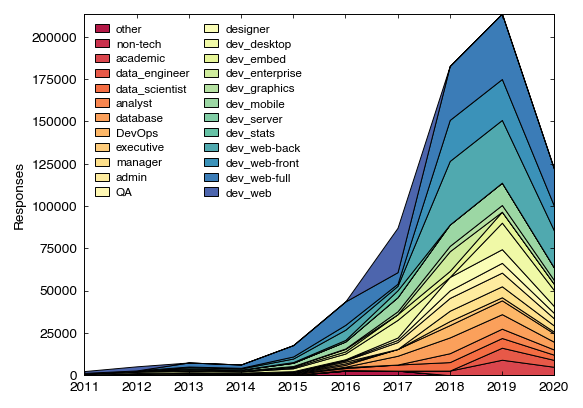

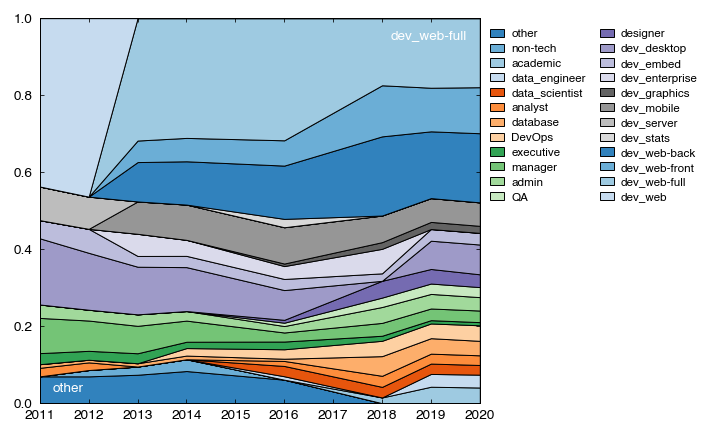

In [75]:
occ_cols = [c for c in df.columns if c.startswith("occupation")]

occ = df[["survey_year"]+occ_cols].groupby("survey_year").sum()
occ.columns = [c.split("_", 1)[-1] for c in occ_cols]

occ_interest = [
    # 'student',  # ignore students
    'other',
    'non-tech',
    'academic',
    'data_engineer',
    'data_scientist',
    'analyst',
    'database',
    'DevOps',
    'executive',
    'manager',
    'admin',
    'QA',
    # 'sales',  very small contribution
    'designer',
    'dev_desktop',
    'dev_embed',
    'dev_enterprise',
    'dev_graphics',
    # 'dev_kernel',  # only included in early surveys
    'dev_mobile',
    'dev_server',
    'dev_stats',
    'dev_web-back',
    'dev_web-front',
    'dev_web-full',
    'dev_web',
]

occ = occ[occ_interest]

mpl_defs(1.2, 1)

fig, ax = plt.subplots()
ax = stackplot(occ, "", cmap="Spectral", ax=ax)
#ax.legend(bbox_to_anchor=(1,1), loc="upper left", ncol=2)
ax.legend(loc=2, ncol=2)
ax.set_ylabel('Responses')
plt.savefig('occupations.png')

occ = occ.divide(occ.sum(axis=1).values, axis=0)

fig, ax = plt.subplots(figsize=(5,3))
ax = stackplot(occ.drop([2015,2017]), "", cmap="tab20c", ax=ax)
ax.legend(bbox_to_anchor=(1,1), loc="upper left", ncol=2)
ax.text(0.03, 0.03, "other", transform=ax.transAxes, color='w')
ax.text(0.97, 0.97, "dev_web-full", transform=ax.transAxes, color='w', ha='right', va='top')
fig.savefig('occu_scaled.png')

I'll focus on the data-focused occupations to see how they evolve. In this case the percentage is specific to each occupation. The other field is included as well to potentially cover earlier years with fewer options for participents to select.

,data_engineer,data_scientist,academic,database,analyst,other
survey_year,,,,,,
2011,0.00,0.00,0.00,0.84,1.98,6.23
2012,0.00,0.00,0.00,0.60,1.74,6.12
2013,0.00,0.00,0.00,0.68,0.00,5.88
2014,0.00,0.00,0.00,0.83,0.00,7.19
2015,0.69,2.13,0.00,0.46,0.00,0.22
2016,0.70,2.11,0.00,0.46,1.02,4.81
2017,0.00,7.00,0.00,10.10,0.00,5.24
2018,0.00,7.80,4.23,14.50,8.15,0.00
2019,9.01,7.29,11.60,10.90,6.99,0.00


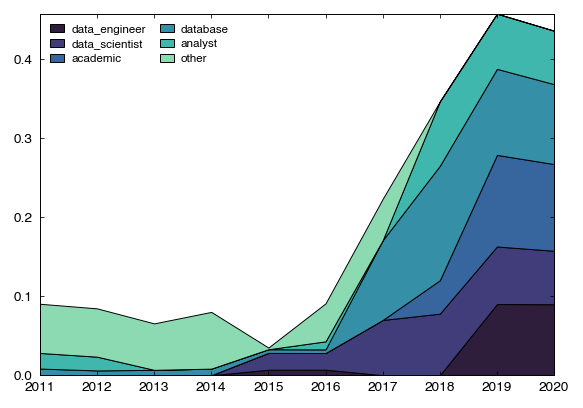

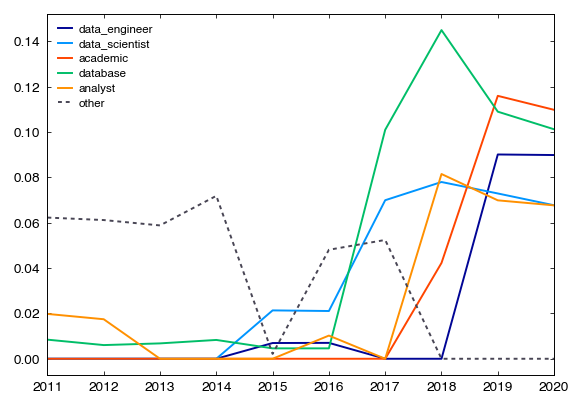

In [71]:
occ_cols = [c for c in df.columns if c.startswith("occupation")]
occ = df[["survey_year"]+occ_cols].replace(np.nan, 0).groupby("survey_year").mean()

occ.columns = [c.split("_", 1)[-1] for c in occ_cols]
occ = occ[[
    'data_engineer',
    'data_scientist',
    'academic',
    'database',
    'analyst',
    'other',
]]

ax = stackplot(occ, "")
ax.legend(loc=2, ncol=2)
plt.savefig('ds.png')

fig, ax = plt.subplots()
for o in occ:
    l, = ax.plot(occ.index, occ[o], lw=1, label=o)
    if o == 'other':
        l.set_dashes((2, 2))
ax.legend(loc=2)
ax.margins(0,0.05)

np.round(occ*100, 2)

Notably, we see a quick increase from around 2015-2016, that outpaces the "other" option, but then levels off. It will be interesting to see future years.

Finally, we can see what other occupations were selected along with "data scientist".

Common links with web developers definitely makes sense (e.g. AirBnB), as well as academics

In [62]:
occ_cols = [c for c in df.columns if c.startswith("occupation")]
occ = df[["survey_year"]+occ_cols].loc[df.occupation_data_scientist == 1]
occ = occ.groupby("survey_year").mean()

occ.columns = [c.split("_", 1)[-1] for c in occ_cols]
occ = occ.dropna(axis=1, how='all').sort_values(by=2020, axis=1, ascending=False)
np.round(occ.drop([2015,2016,2017,2018]).T, 3) * 100

survey_year,2019,2020
data_scientist,100.0,100.0
dev_web-back,47.1,46.3
academic,40.4,39.3
dev_web-full,37.4,36.0
data_engineer,29.6,31.2
analyst,31.4,30.9
dev_web-front,20.9,19.9
dev_desktop,18.4,17.8
database,18.3,17.3
DevOps,12.0,13.4


## Education

Finally, lets have a look at education levels of respondents, both formal and informal training. Like with occupations, each contribution is plotted as a factor of the total of each year. This helps to identify the general make up of respondents, but difficult to follow trends pre-2017 before the category list was standardised.

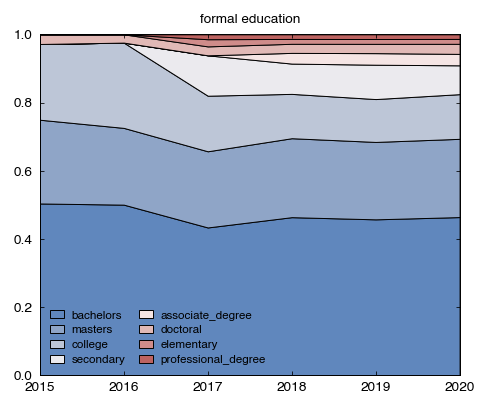

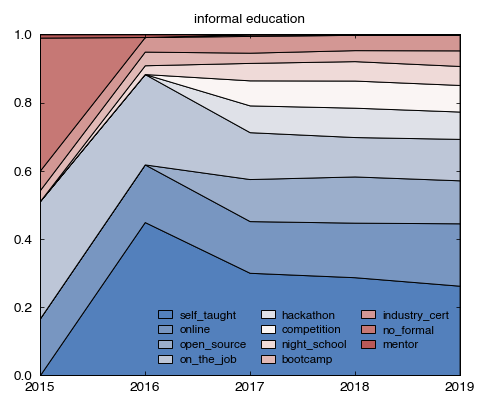

In [22]:
edu_cols = [c for c in df.columns if c.startswith("education")]
edu = df[["survey_year"]+edu_cols].groupby("survey_year").sum()
edu.columns = [c.split("_", 1)[-1] for c in edu_cols]

edu_formal = [
    'elementary',
    'secondary',
    'college',
    'bachelors',
    'masters',
    'doctoral',
    'associate_degree',
    'professional_degree',
]


eduf = edu[edu_formal]
dropcols = [2011, 2012, 2013, 2014]
eduf = eduf.divide(eduf.sum(axis=1).values, axis=0)
eduf = eduf.drop(dropcols).sort_values(by=2019,axis=1, ascending=False)
ax = stackplot(eduf, "formal education", cmap="vlag")
ax.legend(loc=3, ncol=2)

edu_informal = [
    'bootcamp',
    'competition',
    'hackathon',
    'mentor',
    'industry_cert',
    'night_school',
    'no_formal',
    'on_the_job',
    'online',
    'open_source',
    'self_taught'
]

edui = edu[edu_informal]
dropcols = [2011, 2012, 2013, 2014, 2020]
edui = edui.divide(edui.sum(axis=1).values, axis=0)
edui = edui.drop(dropcols).sort_values(by=2019,axis=1, ascending=False)
ax = stackplot(edui, "informal education", cmap="vlag")
ax.legend(loc=4, ncol=3)


Lets focus on a few select education types relevant to the data-science field, split into formal and informal

survey_year,2015,2016,2017,2018,2019,2020
bachelors,31.22,33.71,42.05,45.36,44.57,45.15
masters,15.22,15.17,21.68,22.66,22.13,22.35
doctoral,1.75,1.64,2.55,2.61,2.66,2.88
bootcamp,2.83,5.05,5.31,9.54,14.51,0.00
online,14.68,21.29,26.84,47.31,58.03,0.00
open_source,0.00,0.00,21.84,40.08,39.98,0.00
on_the_job,30.32,33.36,24.34,34.17,38.54,0.00
competition,0.00,0.00,13.00,23.53,24.73,0.00
night_school,0.00,3.24,9.06,16.84,17.66,0.00


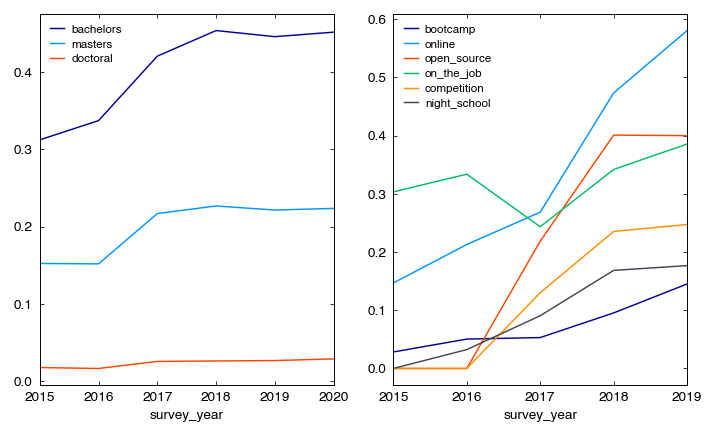

In [23]:
edu_interest_1 = [
    'bachelors',
    'masters',
    'doctoral',
]

edu_interest_2 = [
    'bootcamp',
    'online',
    'open_source',
    'on_the_job',
    'competition',
    'night_school'
]

edu_cols = [c for c in df.columns if c.startswith("education")]
edu = df[["survey_year"]+edu_cols].replace(np.nan, 0).groupby("survey_year").mean()
edu.columns = [c.split("_", 1)[-1] for c in edu_cols]

fig, ax = plt.subplots(1, 2, figsize=(5, 3))
edu[edu_interest_1].drop([2011, 2012, 2013, 2014]).plot(ax=ax[0])
edu[edu_interest_2].drop([2011, 2012, 2013, 2014, 2020]).plot(ax=ax[1])

for axi in ax:
    axi.margins(0, 0.05)

edu = edu[edu_interest_1+edu_interest_2].drop([2011, 2012, 2013, 2014])
np.round(edu * 100, 2).T

Formal education shows a slow trend upwards after 2017.

Unfortuantely, informal education types was not part of the 2020 survey. With the data we have, however, there definitely seems to be a growth across the board in terms of informal education, notably online courses, while on-the-jobn training remains more constant.

## Salary / Compensation

Finally, lets look salaries. I'll look at the top 10 countries based on number of entries, which lines up pretty closely with the G7/G20

In [24]:
countries = df.groupby('country').agg({'salary':'count'}).sort_values(by='salary', ascending=False).iloc[:10]
countries = countries.index

np.round(pd.pivot_table(
    df[df.country.isin(countries)],
    values='salary',
    columns=['survey_year'],
    index='country'
), 1)

survey_year,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
country,,,,,,,,,,
Australia,82527.5,84214.9,85639.1,82612.6,76923.1,71651.4,69215.8,125708.3,171323.3,144676.8
Brazil,NaN,NaN,NaN,27402.6,31173.9,22934.9,20695.8,54998.6,32711.1,25407.5
Canada,68823.5,70363.6,73265.3,70218.6,68342.6,60856.3,56924.9,99496.6,134295.5,115257.7
France,52449.0,50470.6,57555.6,54090.9,47055.1,43137.4,42879.0,88363.9,80811.3,75533.7
Germany,52388.1,54615.4,60038.0,61012.1,53717.4,48644.7,51616.3,91604.5,109154.9,91615.3
India,26521.7,19794.2,20312.5,17580.3,18347.2,15547.4,10318.9,25328.0,26409.1,25402.5
Poland,NaN,NaN,NaN,25238.1,24606.2,25994.8,20851.3,39068.7,38754.3,41950.1
Russia,27241.4,25200.0,27538.5,33000.0,23957.7,17423.3,18442.3,26039.4,29638.1,33509.3
United Kingdom,67510.0,67608.7,72401.6,71020.4,69253.5,65333.6,52602.4,128308.9,166417.1,139698.2


There's a lot going on here. Salary here is represented in USD. I'll focus on the United States to avoid having to account for things like cost of living and variability in exchange rates.

The ranges and bucketing of salaries in the question was changed over time. We can see this severyly affects the distribution, especially for the early years, where the upper limit was "More than $200,000" in 2017

<AxesSubplot:>

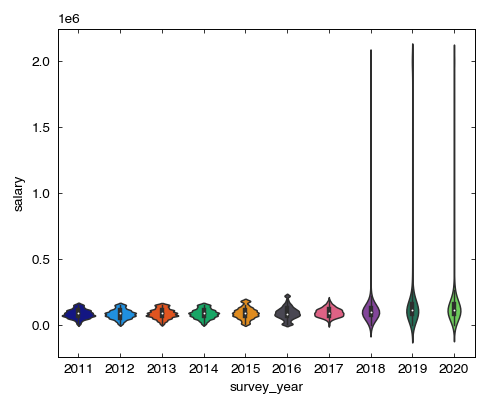

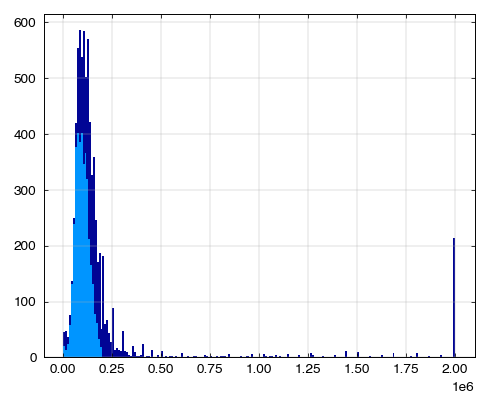

In [25]:
sns.violinplot(x='survey_year',y='salary',data=df.loc[df.country == "United States"])

fig, ax = plt.subplots()
df[(df.country == "United States") & (df.survey_year == 2020)]["salary"].hist(bins=200, ax=ax)
df[(df.country == "United States") & (df.survey_year == 2017)]["salary"].hist(bins=20, ax=ax)


As with the age question, we can remove these outliers to help with a comparison between years by removing the upper outliers

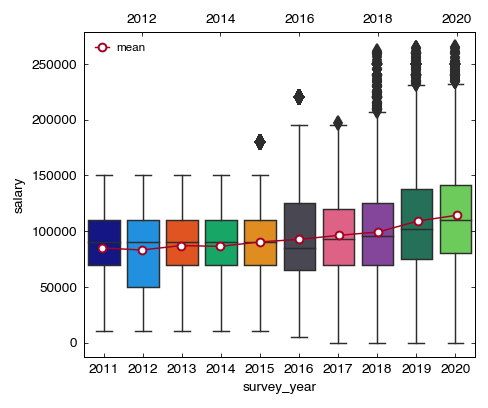

In [26]:
Q = 0.95
ct = df.loc[df.country == "United States"].copy()
ct = ct[ct["salary"] < ct["salary"].quantile(Q)]

ctmean = ct.groupby("survey_year")["salary"].mean()

fig, ax = plt.subplots()
sns.boxplot(x='survey_year',y='salary',data=ct, ax=ax)
axt = ax.twiny()
axt.plot(ctmean, 'o-', color=colours[-1], label="mean", mfc='w')
axt.legend(loc=2)



Even with this correction, the mean continues to increase over time. Let's have a look at what other questions are correlated with salary. I'll do a quick hack to sort the order as a function of "salary". Categorical questions that haven't been one-hot-encoded are also not visible in this list. Country is clearly a massive factor, but that would become very overwhelming.

Let's also drop a few columns that don't appear in many years.

<AxesSubplot:>

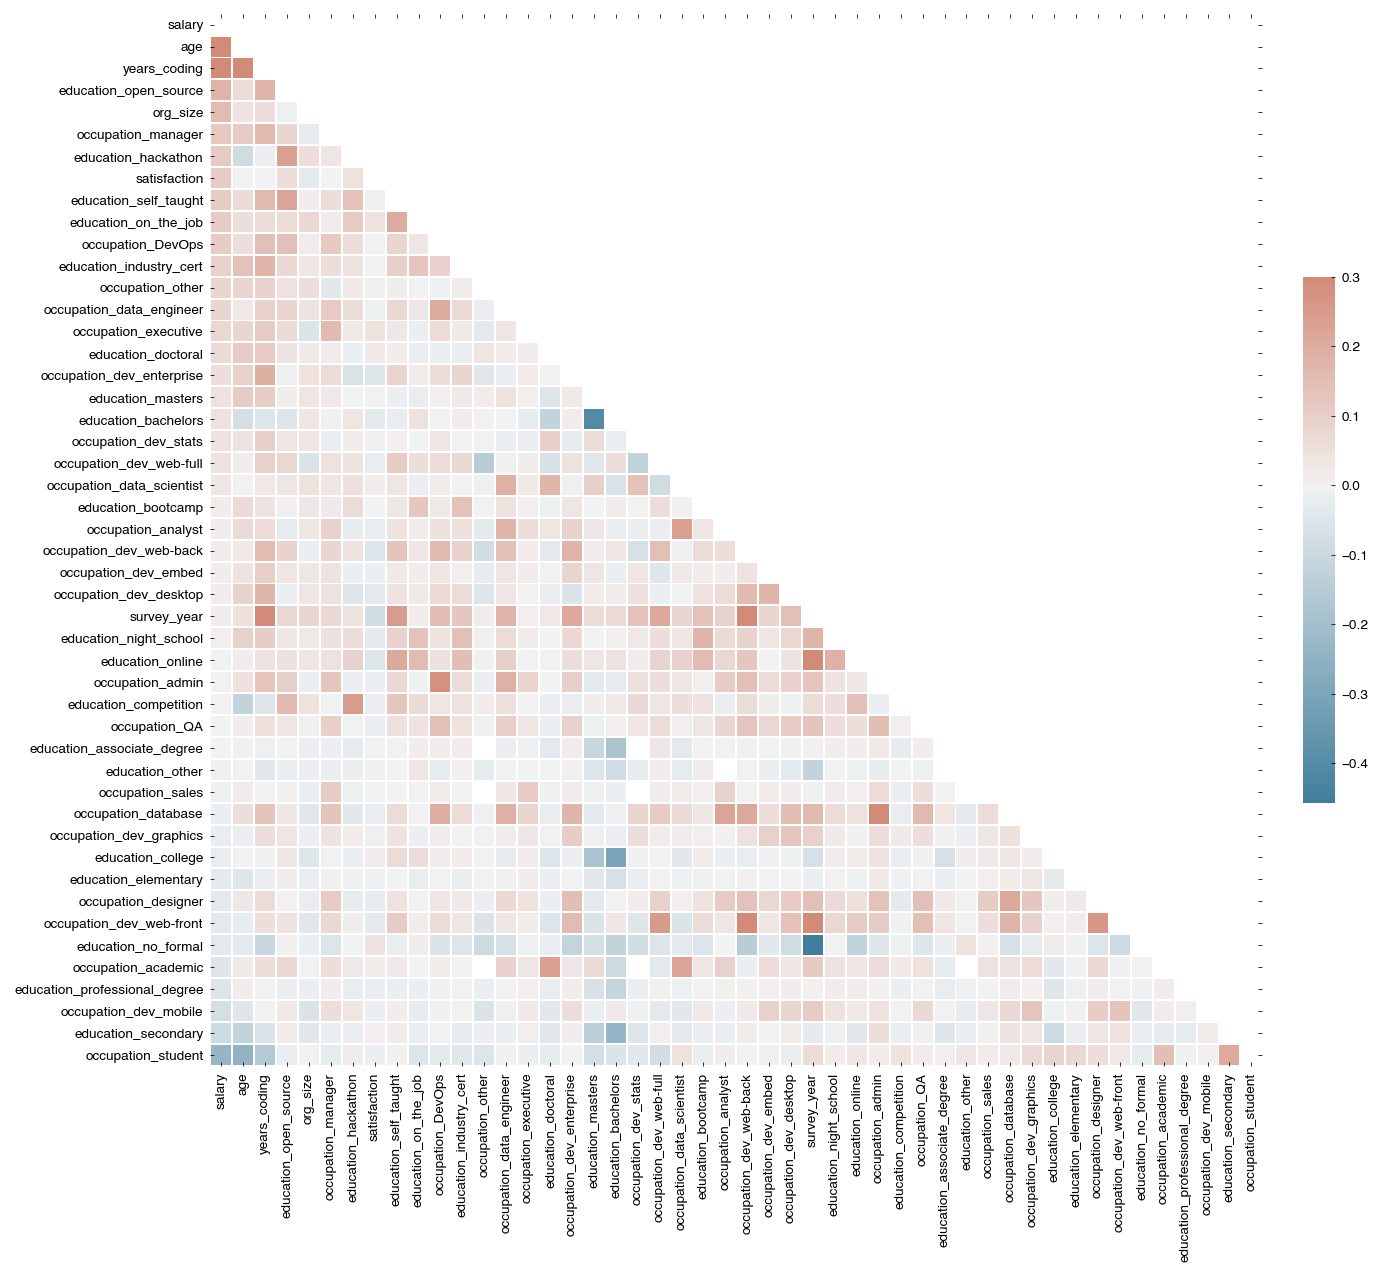

In [27]:
dropcols = [
    'occupation_dev_server',
    'occupation_dev_kernel',
    'occupation_dev_web',
    'occupation_non-tech',
    'education_mentor',
]

Q = 0.95
ct = df.drop(dropcols, axis=1).copy()
ct = ct[ct["salary"] < ct["salary"].quantile(Q)]

covlist = ct.corr().unstack().drop_duplicates().sort_values()
covlist = covlist[covlist < 1]  # remove self correlation

covsort = []
for (f1, f2), c in covlist.iteritems():
    if f1 == 'salary':
        covsort.append(f2)
    elif f2 == 'salary':
        covsort.append(f1)

covmat = ct[['salary']+covsort[::-1]].corr()

mask = np.triu(np.ones_like(covmat, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(covmat, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
f.savefig('cv.png')


Biggest positive
- age/years_coding: makes sense
- satisfaction: money clearly does bring happiness

Biggest negative
- student: makes sense
- mobile development: ouch!

Takeaway: Getting a good education is important!

survey_year doesn't have any real overall correlation with salary, which is a good sign that there aren't huge issues with the approach taken to combine the surveys.

## Linear Regression

Finally, lets see if a simple linear regression model can capture the relationship between participant quetsions and our target salary variable.

First we have to do a bit more cleaning of the data with ```clean_data```
- drop entries with no salary, as well as any empty columns
- Remove nans from the one-hot-encoded columns (education and occupation)
- Remove nans from remaining columns by imputing means. A more comprehensive approach should be applied to develop the model further
- One-hot-encode the remaining categorical columns (notably, countries)

Then, use the usual approach
- split the dataset into train and test groups, stratified by survey_year
- Standardise the distributions.
- Use a ridge regressor, which uses L1-regularizer to ensure a sparse dataset. This is important here as it will effectively remove the parameters that are barely correlated.

In [28]:
def clean_data(df):

    df = df.copy()
    df.dropna(subset=['salary'], inplace=True)
    df.dropna(how='all', axis=1, inplace=True)

    # split the target variable from the dataset
    y = df['salary']
    df.drop('salary', axis=1, inplace=True)

    # convert nans to 0 in the one-hot-encoded columns
    for col in df.columns:
        if col.startswith("occupation_") or col.startswith("education_"):
            df[col].isna() == 0

    # separate numerical from categorical
    df_num = df.select_dtypes(include=np.number)
    df_cat = df.select_dtypes(include='object')

    # join numerical with nan filled with mean and one hot encoding for categorical
    X = pd.concat([
        df_num.apply(lambda col: col.fillna(col.mean())),
        pd.get_dummies(df_cat, dummy_na=False, drop_first=True)
    ], axis=1)

    return X, y


def run_regression(X, y, alpha=0, test_size=.3, random_state=19):
    '''
    INPUT
    X - pandas dataframe, X matrix
    y - pandas dataframe, response variable
    alpha - float, L1-regularizer
    test_size - float between 0 and 1, default 0.3, determines the proportion of data as test data
    random_state - int, default 19, controls random state for train_test_split

    OUTPUT
    test_score - list of floats of r2 scores on the test data
    train_score - list of floats of r2 scores on the train data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train_test_split used for model
    '''

    reduce_X = X.iloc[:, (X.sum() > cutoff).values]

    X_train, X_test, y_train, y_test = train_test_split(
            reduce_X,
            y,
            test_size=test_size,
            random_state=random_state
        )

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    lm_model = Ridge(alpha=alpha)

    lm_model.fit(X_train, y_train)

    # Predict using your model
    y_test_preds = lm_model.predict(X_test)
    y_train_preds = lm_model.predict(X_train)

    # Score using your model
    test_score = r2_score(y_test, y_test_preds)
    train_score = r2_score(y_train, y_train_preds)

    print(reduce_X.shape)
    print(train_score, test_score)

    return test_score, train_score, lm_model, X_train, X_test, y_train, y_test



First, use the full dataset, with no regularisation

In [29]:
X, y = clean_data(df.copy())

result = run_regression(X, y, alpha=0.01)

NameError: name 'cutoff' is not defined

That's really not good. Lets incorporate some L1-regularisation to sparsify the dataset and focus to focus on the most relevant parameter-space

In [54]:
result = run_regression(X, y, alpha=0.01)

(213865, 331)
0.10941785091281564 0.10684420967758812


That isn't great. Let's try removing those salary outliers

In [55]:
Q = 0.95
df2 = df.copy()
df2 = df2[df2["salary"] < df2["salary"].quantile(Q)]

X, y = clean_data(df2)
result = run_regression(X, y, alpha=0.01)

(203027, 330)
0.6312640418001656 0.6279173383883323


Much better, but still not amazing. More normal distributions helps linear regessssor optimise.

Further improvement would require more careful conditioning, imputing and combination of the datasets, as well as potentially moving beyond a linear regression model.